In [1]:
import numpy as np


import os, glob
import astropy.io.fits as pyfits
from matplotlib import pyplot as plt
import scipy
import pandas as pd
import csv
import numpy.polynomial.polynomial as poly
from scipy.integrate import quad
# import detrend as de
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy import interpolate

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})


from astropy.io import ascii

import lightkurve as lk
from lightkurve import search_lightcurvefile

import time as ttt

# 1. Light curve preprocessing and flare candidates collection.
## 1.1 Download a TESS short cadence light curve
## 1.2 Flare candidates collection
## 1.3 Estimate the four features/characteristics of all flare candidates

# 2. Flare identification with Machine-Learning models
## 2.1 Load the models
## 2.2 Input the four features to the models for flare identification

## 1.1 Download a TESS short cadence light curve
## TIC 434103039 for the example

In [2]:
#the directory for the data storage. 
#change the directory address for your own convenience.
save_path = 'outputs'

In [3]:
#TIC	Number of Sectors	Number of Flares
#364588501	34	559
#201883033	4	110
#140045538	3	229
#441398770	3	169
#229147927	5	58
#63781635	2	17
#25118964	33	355
#231017428	4	97
#234506911	6	98
#220433363	22	845
#231914259	6	157
#365006789	3	75
#150359500	32	857
#388857263	4	117

In [4]:
import lightkurve as lk

tic_id = '140045538'
search_result = lk.search_lightcurve(f"TIC {tic_id}", author="SPOC")
search_result

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120   140045538      0.0
  1 TESS Sector 28 2020   SPOC      20   140045538      0.0
  2 TESS Sector 28 2020   SPOC     120   140045538      0.0
  3 TESS Sector 68 2023   SPOC      20   140045538      0.0
  4 TESS Sector 68 2023   SPOC     120   140045538      0.0
  5 TESS Sector 95 2025   SPOC     120   140045538      0.0

In [5]:
TIC = 'TIC 140045538'
lcc = lk.search_lightcurve(TIC, author="SPOC", sector=1,cadence='short')

In [6]:
lcc.table["dataURL"]

<MaskedColumn name='dataURL' dtype='str73' length=1>
mast:TESS/product/tess2018206045859-s0001-0000000140045538-0120-s_lc.fits

In [7]:
search_result = lcc.download_all(download_dir=save_path)

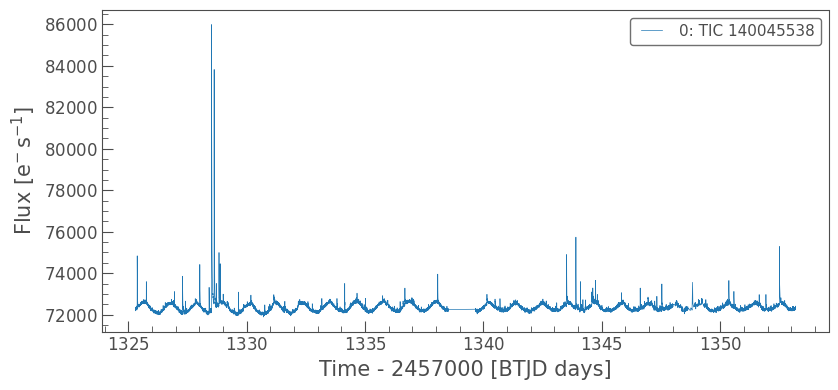

In [8]:
search_result.plot()
plt.show()

In [9]:
search_result[0].head()

<TessLightCurve length=5 LABEL="TIC 140045538" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
1325.3004032409592  7.2234797e+04 ...  2.2464739e-02  5.9155762e-02
1325.3017921432606  7.2188492e+04 ... -2.2703882e-03  2.6285123e-02
 1325.303181045562  7.2207766e+04 ... -6.7850789e-03  2.2310857e-02
1325.3045699478632  7.2235648e+04 ... -7.8595541e-03  1.0938278e-02
 1325.305958849699  7.2302422e+04 ... -1.1981726e-02  1.1425514e-02

In [10]:
# time0.value

In [11]:
#pdcsap normalized light curve
plt.figure(figsize=(11,4))
plt.title('PDCSAP light curve')
time0 = search_result[0]['time'][search_result[0]['quality']==0].value
pdc0 = search_result[0]['pdcsap_flux'][search_result[0]['quality']==0].value 
pdc0 = np.array(pdc0) 

nor_pdc0 = pdc0 / np.nanmedian(pdc0)  - 1
plt.plot(time0, nor_pdc0)


plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [12]:
#detrend the light curve by using the "flatten" funciton for 2 iteration
#the users can detrend the light curves with their own prefer methods

flatten_lc = search_result[0].flatten(window_length=201, polyorder=1, \
return_trend=False, break_tolerance=5, niters=2, \
sigma=3, mask = search_result[0]['quality'] != 0 ).to_pandas()
flatten_lc = flatten_lc.reset_index(drop=0)


fmean4 = np.nanmean(flatten_lc['flux'][flatten_lc['quality']==0])
fstd4 = np.nanstd(flatten_lc['flux'][flatten_lc['quality']==0])
fmedian4 = np.nanmedian(flatten_lc['flux'][flatten_lc['quality']==0])
fmad4 = np.nansum(abs(flatten_lc['flux'][flatten_lc['quality']==0]-fmedian4))/len(flatten_lc['flux'][flatten_lc['quality']==0])

mask1 = np.abs(flatten_lc['flux'] - 1) > 3 * fmad4
# mask1 = flatten_lc['flux'] > fmedian4 + 3 * fmad4

# mask1 = flatten_lc['flux'] > fmedian4 + 3 * fstd4
mask1 = mask1.values


#second flatten
mask2 = []
for i,v in enumerate(search_result[0]['quality'] != 0 ):
    if v == mask1[i]: 
        if v == False:
            mask2.append(False)

        if v == True:
            mask2.append(True)

    if v != mask1[i]:
        mask2.append(True)

mask2 = np.array(mask2)


flatten_lc2 = search_result[0].flatten(window_length=111, polyorder=2, \
                                      return_trend=False, break_tolerance=5, niters=5, \
                                      sigma=3, mask= mask2 ).to_pandas()
flatten_lc2 = flatten_lc2.reset_index(drop=0)

In [13]:
flatten_lc2.head()

time      flux  flux_err  timecorr  cadenceno  centroid_col  \
0  1325.300403  0.999090   0.00043  0.004668      70445    528.816611   
1  1325.301792  0.998449   0.00043  0.004668      70446    528.792890   
2  1325.303181  0.998716   0.00043  0.004669      70447    528.788629   
3  1325.304570  0.999101   0.00043  0.004669      70448    528.787195   
4  1325.305959  1.000025   0.00043  0.004669      70449    528.783770   

   centroid_row      sap_flux  sap_flux_err      sap_bkg  ...  psf_centr1  \
0   1068.567149  69163.593750     29.485779  2447.421387  ...         NaN   
1   1068.535585  69151.296875     29.482016  2457.644043  ...         NaN   
2   1068.531248  69181.195312     29.487997  2453.665771  ...         NaN   
3   1068.520758  69217.093750     29.501167  2470.340820  ...         NaN   
4   1068.521487  69257.984375     29.500063  2455.480957  ...         NaN   

   psf_centr1_err  psf_centr2  psf_centr2_err  mom_centr1  mom_centr1_err  \
0             NaN         NaN             NaN  528.816611        0.000336   
1             NaN         NaN             NaN  528.792890        0.000337   
2             NaN         NaN             NaN  528.788629        0.000337   
3             NaN         NaN             NaN  528.787195        0.000337   
4             NaN         NaN             NaN  528.783770        0.000337   

    mom_centr2  mom_centr2_err  pos_corr1  pos_corr2  
0  1068.567149        0.000356   0.022465   0.059156  
1  1068.535585        0.000356  -0.002270   0.026285  
2  1068.531248        0.000357  -0.006785   0.022311  
3  1068.520758        0.000357  -0.007860   0.010938  
4  1068.521487        0.000357  -0.011982   0.011426  

[5 rows x 24 columns]

In [14]:
plt.figure(figsize=(11,4))

plt.title('Detrended light curve')

time1 = flatten_lc2['time'][flatten_lc2['quality']==0]
nor_pdc1 = flatten_lc2['flux'][flatten_lc2['quality']==0] -  1

plt.plot(time1, nor_pdc1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

In [15]:
len(time0), len(time1)

(18230, 18230)

In [16]:
# detrend_fits = nor_pdc0 - nor_pdc1 

# plt.figure(figsize=(11,4))
# plt.plot(time0, nor_pdc0)

# plt.plot(time0, detrend_fits)
# # plt.xlim(1375,)
# plt.xlabel('BTJD days')
# plt.ylabel('Nor. Flux')
# plt.show()

## 1.2 Flare candidates collection

Please read Section 2.1 in the paper for the criteria for flare canddiates selection.

In [17]:
fmean3 = np.nanmean(nor_pdc1)
fstd3 = np.nanstd(nor_pdc1)
fmedian3 = np.nanmedian(nor_pdc1) 
fmad3 = np.nansum(abs(nor_pdc1-fmedian3))\
/len(nor_pdc1)
mask3 = np.abs(nor_pdc1) > 3 * fstd3
mask3 = mask3.values

fmean4 = np.nanmean(np.ma.array(nor_pdc1.values, mask=mask3)) 
fmedian4 = np.nanmedian(np.ma.array(nor_pdc1.values, mask=mask3)) 
fstd4 = np.nanstd(np.ma.array(nor_pdc1.values, mask=mask3))

nor_pdc2 = nor_pdc1 - fmedian4

from itertools import groupby
from operator import itemgetter

time1 = time1.reset_index(drop=1)
nor_pdc2 = nor_pdc2.reset_index(drop=1)
# collect flare candidate
time1_sel3 = time1[nor_pdc2 >   1 * fstd4]

ind_f3 = time1_sel3.index

ind_f_cadi = []
for k, g in groupby(enumerate(ind_f3), lambda ix : ix[0] - ix[1]):
#     print( list(map(itemgetter(1), g)))
    ind_f_cadi.append(list(map(itemgetter(1), g)))

/Users/kyrabettwy/venvs/tf213/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [18]:
print('sigma of detrended light curve is ', fstd4)

sigma of detrended light curve is  0.0009397177743685514


In [19]:
ind_f = []
ind_f_cadi3 = []
# ind_f_cadi4 = []

flare_time_start = []
flare_time_end = []
flare_time_peak = []

flare_peak_amplitude = []



for i,v in enumerate(ind_f_cadi):
    ind_f_cand = ind_f_cadi[i]
    if len(ind_f_cand) >= 3:
        try:
            flare_time_start.append( time1[ind_f_cand[0]-1] ) 
            flare_time_end.append( time1[ind_f_cand[-1]+1])
            flare_time_peak.\
            append(time1.loc[ind_f_cand][nor_pdc2.loc[ind_f_cand] == np.max(nor_pdc2.loc[ind_f_cand])].values[0])
            
            flare_peak_amplitude.append(np.max(nor_pdc2.loc[ind_f_cand]))
            
            ind_f.append(i)
            ind_f_cadi3.append(ind_f_cand)


        except ValueError and KeyError:
            pass

In [20]:
print(len(ind_f), 'flare candidates')

130 flare candidates


In [21]:
# %matplotlib notebook

In [22]:
time1.loc[v[0]-1 : v[-1]+1].values

array([1353.17660999, 1353.17799885, 1353.1793877 ])

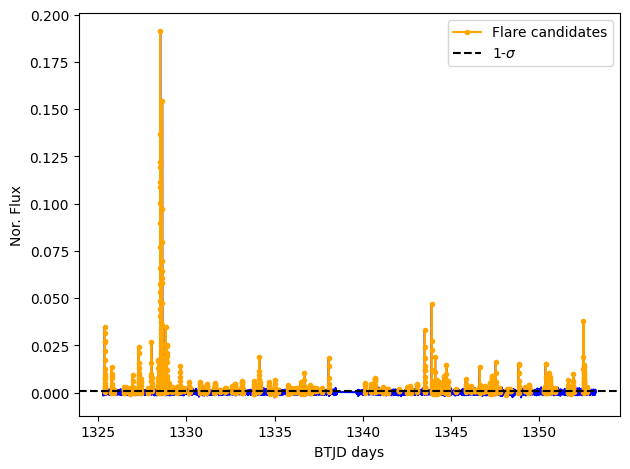

In [23]:
#normalized light curves
plt.plot(time1, nor_pdc2, color='b')

time1_candidates = []
nor_pdc2_candidates = []
#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if i ==0:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
                 '.-',color='orange', label='Flare candidates')
    else:
        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')
    
    time1_candidates.append(time1.loc[v[0]-1 : v[-1]+1].values)
    nor_pdc2_candidates.append(nor_pdc2.loc[v[0]-1 : v[-1]+1].values)

plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

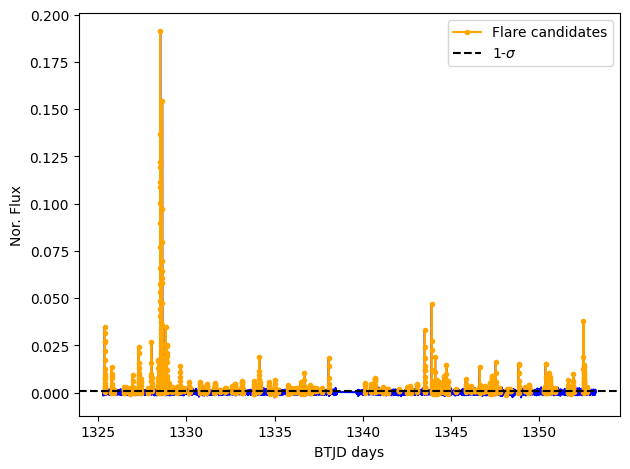

In [24]:
#normalized light curves
plt.plot(time1, nor_pdc2, color='b')

#flare candidates
for i,v in enumerate(ind_f_cadi3):
    if i ==0:

        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
                 '.-',color='orange', label='Flare candidates')
    else:
        plt.plot(time1.loc[v[0]-1 : v[-1]+1], nor_pdc2.loc[v[0]-1 : v[-1]+1], \
         '.-',color='orange')


plt.axhline(y = fstd4, linestyle='--', color='black', label=r'1-$\sigma$')

plt.legend(loc=1)
plt.xlabel('BTJD days')
plt.ylabel('Nor. Flux')
plt.show()

## 1.3 Estimate the four features/characteristics of all flare candidates

### 1. The duration of the flare candidate ($\delta t$) in days.
### 2. The impulsive-decay time ratio ($\delta t_1 / \delta t_2$).
### 3. The upper-to-lower equivalent duration ratio ($ED_1 / ED_2$).
### 4. The peak amplitude signal-to-noise ratio ($A_f / \sigma$).

Please read the Section 2.1, Section 2.2, and Figure 1 in our paper for more specific details.


In [25]:
# 1. duration delta_t in days
flare_time_end = np.array(flare_time_end)
flare_time_start = np.array(flare_time_start)

delta_t = flare_time_end - flare_time_start

In [26]:
# delta_t

In [27]:
# 2. impulsive-decay time ratio (delta_t1/delta_t2)
flare_time_peak  = np.array(flare_time_peak)

delta_t1 = flare_time_peak - flare_time_start
delta_t2 = flare_time_end - flare_time_peak


delta_t1_to_delta_t2 = delta_t1 / delta_t2

In [28]:
# delta_t1_to_delta_t2

In [29]:
#3. The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
# The equation of equivalent duration
def ED(x, y): #equivalent duration in second
    
    ef = 0
    for i2,v2 in enumerate(x):
        try:
#             print(x[i2], x[i2+1])

            '''1-D linear fitting'''
            coefs = poly.polyfit(x[i2:i2+2], y[i2:i2+2] ,1)

            '''1-D linear function for equivalent duration (ED) flare energy estimate method'''
            ew_flare_1 = lambda x :  coefs[1]*x+coefs[0]

            '''Integrate 1-D linear function for ED'''
            e1 = quad(ew_flare_1, x[i2], x[i2+1])
#             print(e1[0])
            ef+=e1[0]
        except IndexError:
            pass
        
    return ef * 86400

In [30]:
nor_pdc2_candidates[0]

array([0.00043423, 0.02701726, 0.03472451, 0.03139561, 0.02673958,
       0.0221887 , 0.01712276, 0.01251952, 0.00986667, 0.008329  ,
       0.00706455, 0.00488747, 0.00264224, 0.00331252, 0.00291433,
       0.00240343, 0.00123721, 0.00136517, 0.00098269, 0.00105546,
       0.00058833])

In [31]:
ED_all = []
ED1 = []
ED2 = []

for i,v in enumerate(nor_pdc2_candidates):
    time_fcad = time1_candidates[i]
    norf_fcd = nor_pdc2_candidates[i]
    amp_peak = flare_peak_amplitude[i]

    f = interpolate.interp1d(time_fcad, norf_fcd)
    t_array = np.linspace(np.nanmin(time_fcad), np.nanmax(time_fcad), 100)
    f_array = f(t_array)
    a = ED(t_array,  f_array)
    a2 = ED(t_array[ f_array < amp_peak/2],   f_array[ f_array < amp_peak/2 ])
    a1 = a - a2
    
    ED_all.append(a)
    ED1.append(a1)
    ED2.append(a2)

/Users/kyrabettwy/venvs/tf213/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [32]:
len(ED_all)

130

In [33]:
# ED1

In [34]:
# ED2

In [35]:
# The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
ED1 = np.array(ED1)
ED2 = np.array(ED2)

ED1_to_ED2 = ED1 / ED2

/var/folders/3l/xp5scxws3kn9d72khd66rw7w0000gn/T/ipykernel_26099/1809543040.py:5: RuntimeWarning: divide by zero encountered in divide
  ED1_to_ED2 = ED1 / ED2


In [36]:
# ED1_to_ED2

In [37]:
#4. Peak amplitude to noise ratio 
flare_peak_amplitude = np.array(flare_peak_amplitude)
amp_to_std_ratio = flare_peak_amplitude / fstd4

In [38]:
# flare_peak_amplitude

In [39]:
# amp_to_std_ratio

In [40]:
# now you have all four features for all flare candidates

# 1. duration delta_t in days
delta_t
# 2. impulsive-decay time ratio (delta_t1/delta_t2)
delta_t1_to_delta_t2
#3. The upper-to-lower equivalent duration ratio ( 𝐸𝐷1/𝐸𝐷2 )
ED1_to_ED2
#4. Peak amplitude to noise ratio 
amp_to_std_ratio

array([ 36.95205904,  14.28044815,   1.40005228,   2.94046453,
         3.04319487,   2.63581453,   1.82447181,   1.8303464 ,
         2.75526142,   1.99078164,  10.01033858,   1.82053056,
        25.88313267,   2.6859055 ,   7.77865462,   2.69443262,
        28.65563003,  18.06954982,   2.01532595, 203.38957458,
       164.2192504 ,  15.64633594,   1.5893433 ,  36.67989282,
        26.765273  ,   5.54429886,   3.14695631,   3.33327537,
        14.80810663,   2.58080332,   5.94944121,   6.15262712,
         2.69078861,   3.31573951,   4.97788235,   1.61582239,
         2.53109817,   5.1005707 ,   1.47006113,   2.45386866,
         2.35826041,   3.51251232,   5.0380623 ,   2.74699907,
         6.70027943,   6.6521977 ,   2.76417026,   2.45976232,
        19.76608575,   5.79087692,   2.18541528,   2.45373326,
         7.13627023,   2.10333018,   1.60493175,   3.99761521,
         2.14833336,   2.79501518,   2.10956724,   2.82717701,
         2.46134411,   5.86644096,   3.25882506,  11.09

In [41]:
input_candidates = \
pd.DataFrame([], columns=['t_peak', 'delta_t', 't1/t2', 'ED1/ED2', 'Af/STD', 'class'])

input_candidates['t_peak'] = flare_time_peak
input_candidates['delta_t'] = delta_t
input_candidates['t1/t2'] = delta_t1_to_delta_t2
input_candidates['ED1/ED2'] = ED1_to_ED2
input_candidates['Af/STD'] = amp_to_std_ratio
input_candidates.head()

t_peak   delta_t     t1/t2   ED1/ED2     Af/STD class
0  1325.378182  0.027778  0.111111  0.342033  36.952059   NaN
1  1325.762907  0.012500  0.285714  0.321555  14.280448   NaN
2  1325.907353  0.005556  1.000000  0.636404   1.400052   NaN
3  1326.472636  0.006945  0.666667  0.373917   2.940465   NaN
4  1326.562914  0.008333  0.500000  0.270599   3.043195   NaN

In [42]:
len(input_candidates)

130

In [43]:
## saving outputs as a csv file

input_candidates.to_csv("flare_outputs/364588501_TESS11.csv", index=False)

In [370]:
%matplotlib inline